In [2]:
import sys
import json
import torch
import _jsonnet
import matplotlib.pyplot as plt
sys.path.append("/export/ssd/paxia/incremental_coref")

In [3]:
import inference
import util
import logging
from incremental import Incremental

logger = logging.getLogger()
logger.setLevel(logging.INFO)
config = json.loads(_jsonnet.evaluate_file("../experiments.jsonnet"))["spb_on_512"]
eval_data = util.load_data(config["eval_path"])# [:20]
incremental_model = Incremental(config)
if config["load_model"] != "false":
    try:
        checkpoint = torch.load(config["log_path"], map_location="cpu")
        logging.info(f"Found old model at {config['log_path']}, loading instead")
        missing, unexpected = incremental_model.load_state_dict(checkpoint["model"])
        if missing or unexpected:
            print (missing, unexpected)
    except Exception as e:
        logging.info(f"Old model not found or failed to load: {e}")
predictor = inference.Predictor(incremental_model, eval_data)


INFO:root:Loaded 343 examples.
INFO:root:Putting Encoder, GenreEmbedder, SpanScorer, and ScoringModule all on cuda
INFO:transformers.tokenization_utils:Model name '/export/ssd/paxia/incremental_coref/encoders/spanbert_large' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, bert-base-finnish-uncased-v1, bert-base-dutch-cased). Assuming '/export/ssd/paxia/incremental_coref/encoders/spanbert_large' is a path, a model identifier, or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't f

In [4]:
with torch.no_grad():
    all_clusters = predictor.evaluate(perf=True, inspect=67)


INFO:root:loss count 0 and sampled loss count 0
42.8388: 343it [00:00, 1004.12it/s]
INFO:root:cn: 40 and wn: 0
INFO:root:ca: 12 and wa: 3
INFO:root:Evaluation on 343 documents [42.839] took 0.3 seconds
INFO:root:__@ALL: 0.778, 0.857, 0.815, (1 docs)
INFO:root:_genre0_speaker_False: 0.778, 0.857, 0.815, (1 docs)
INFO:root:_genre_bn_t_128-256: 0.778, 0.857, 0.815, (1 docs)
INFO:root:_s_1: 0.778, 0.857, 0.815, (1 docs)
INFO:root:_t_128-256: 0.778, 0.857, 0.815, (1 docs)
INFO:root:bn: 0.778, 0.857, 0.815, (1 docs)
INFO:root:[(129, 1.4580302238464355)]


In [4]:
for doc in range(343):
    clusters = all_clusters[doc]
    gold = eval_data[doc]["clusters"]
    # print (eval_data[doc]["sentences"])
    print (doc, len(gold))

0 12


IndexError: list index out of range

In [5]:
# doc = 224
# doc = 124
doc = 67
clusters = all_clusters[0]
gold = eval_data[doc]["clusters"]
print (eval_data[doc]["doc_key"])
print(eval_data[doc]["sentences"][0])

bn/cnn/00/cnn_0030_0
['[CLS]', 'President', 'Clinton', 'may', 'travel', 'to', 'North', 'Korea', 'in', 'an', 'attempt', 'to', 'improve', 'relations', 'with', 'that', 'country', '.', 'The', 'announcement', 'comes', 'after', 'two', 'days', 'of', 'talks', 'between', 'American', 'and', 'North', 'Korean', 'leaders', 'in', 'Washington', '.', 'Secretary', 'of', 'State', 'Madeleine', 'Al', '##bright', 'has', 'accepted', 'an', 'invitation', 'to', 'visit', 'North', 'Korea', 'and', 'meet', 'with', 'leader', 'Kim', 'Jong', '-', 'il', '.', 'She', 'made', 'the', 'unexpected', 'announcement', 'at', 'a', 'dinner', 'last', 'night', 'in', 'Washington', '.', 'North', 'Korea', "'", 's', 'top', 'defense', 'official', 'hosted', 'the', 'event', '.', 'The', 'country', 'is', 'on', 'a', 'U', '.', 'S', '.', 'list', 'of', 'nations', 'that', 'sponsor', 'terrorism', '.', 'The', 'Clinton', 'administration', 'is', 'trying', 'to', 'persuade', 'North', 'Korea', 'to', 'halt', 'its', 'ballistic', 'missile', 'program', 'as

In [6]:
c = [s for s in clusters.get_cluster_embs()]
sizes = [len(s[1]) for s in c]
print (sizes)
labels = util.flatten([[[idx, emb.cpu().numpy()] for emb in embs] for idx, embs in c])
multilabels = [i for i, c in enumerate(sizes) if c > 1]
print (multilabels)
# [[span.bracket_string() for span in cluster.spans] for i, cluster in enumerate(clusters.clusters) if i in multilabels]
unflat_strings = [[" ".join(span.bracket_string()).replace(" ##", "") for span in cluster.spans] for cluster in clusters.clusters]
strings = util.flatten(unflat_strings)
alpha = util.flatten([[f"{w:.2f}" for w in cluster.merge_data] for cluster in clusters.clusters])
print (len(labels), len(strings))
print ([s for s in unflat_strings if len(s) > 1])
gold_map = {tuple(t): i for i, cluster in enumerate(gold) for t in cluster}
gold_labels = util.flatten([[gold_map.get((span.start, span.end), -1) for span in cluster.spans] for cluster in clusters.clusters])
print (len(gold_labels))
print (gold_map)
print (alpha)

[2, 1, 1, 2, 1, 8, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]
[0, 3, 5, 13, 18, 19, 28, 35]
56 56
[['President Clinton', 'Clinton'], ['travel', "Albright ' s trip"], ['North Korea', 'that country', 'North Korea', "North Korea ' s", 'The country', 'North Korea', 'its', 'it'], ['The announcement', 'the unexpected announcement'], ['Washington', 'Washington'], ['Secretary of State Madeleine Albright', 'She', "Albright ' s"], ['a dinner', 'the event'], ['a U . S . list of nations that sponsor terrorism', 'the list']]
56
{(1, 2): 0, (99, 99): 0, (6, 7): 1, (109, 109): 1, (116, 116): 1, (105, 106): 1, (82, 83): 1, (47, 48): 1, (71, 74): 1, (15, 16): 1, (69, 69): 2, (33, 33): 2, (35, 40): 3, (130, 133): 3, (58, 58): 3, (130, 134): 4, (46, 46): 4, (79, 80): 5, (64, 69): 5, (120, 121): 6, (86, 96): 6}
['0.46', '0.54', '1.00', '1.00', '0.50', '0.50', '1.00', '0.21', '0.15', '0.06', '0.14', '0.21', '0.14', '0.05', '0.04', '1.00', '1.00'

In [7]:
import seaborn as sns; sns.set()
def mscatter(x,y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    ax = ax or plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [63]:
from sklearn.manifold import TSNE

def do(rs):
    model = TSNE(n_components=2, random_state=rs)
    #Note that the following line might use a good chunk of RAM
    z_embed = model.fit_transform([l[1] for l in labels])
    z_labels = [l[0] for l in labels]
    print (z_labels)
    return z_embed, z_labels

In [100]:
def plot(rs):
    z_embed, z_labels = do(rs)
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 4)
    # lz_embed = list(zip(z_embed, new_labels))
    colors = ['b', 'r', 'y', 'c', 'm', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:orange', 'tab:brown', 'tab:cyan']
    markers = ['v', '^', '<', '>', '8', 's', 'p', 'P', '*', 'h', '+', 'x']
    if len(multilabels) > len(colors):
        print ("need more colors")
    color_map = dict(zip(multilabels, colors))
    marker_map = dict(zip(multilabels, markers))
    def map_color(label):
        return color_map.get(label, 'xkcd:light grey')
    def map_shape(label):
        return marker_map.get(label, 'o')
    mapped_colors = [map_color(l) for l in z_labels]
    mapped_shapes = [map_shape(l) for l in z_labels]
    mscatter(z_embed[:,0], z_embed[:, 1], ax=ax, color=mapped_colors, m=mapped_shapes, s=36)
    ax.set_yticks([])
    ax.set_xticks([])
    for i, txt in enumerate(z_labels):
        if txt in multilabels or gold_labels[i] != -1:
            # print(strings[i])
            if gold_labels[i] == "-1": 
                tag = " (X)"
            elif txt in multilabels:
                tag = f" ({gold_labels[i]}, {alpha[i]})"
            else:
                tag = f" ({gold_labels[i]})"
#             if strings[i] == "She":
#                 offset = (1.5/3, 2.5/3)
#             elif "terrorism" in strings[i]:
#                 strings[i] = "a U . S . list of nations \nthat sponsor terrorism"
#                 offset = (3.5/3, -5.4/3)
#             elif "last night" in strings[i]:
#                 strings[i] = "a dinner last night \nin Washington"
#                 offset = (3/3, -5.4/3)
#             else:
            offset = (3/3, -1.4/3)
            ax.annotate(strings[i] + tag, z_embed[i], xytext=z_embed[i] + offset, fontsize=10)
        # elif txt % 12 == 2:
        #    ax.annotate(strings[i], z_embed[i], xytext=z_embed[i] + (0.25, -1), fontsize=14)

    # import matplotlib.patches as mpatches

    # classes = ['ARG*','R-ARG*','C-ARG*']
    # class_colours = ['b','r','y']
    # recs = []
    # for i in range(0,len(class_colours)):
    #    recs.append(mpatches.Rectangle((0,0),0.5,0.5,fc=class_colours[i]))
    # plt.legend(recs,classes,loc=4)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    #plt.savefig("dev67.svg")
    # plt.savefig('dev12.svg')

[0, 0, 1, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18, 18, 19, 19, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 28, 29, 30, 31, 32, 33, 34, 35, 35, 36, 37, 38, 39, 40]


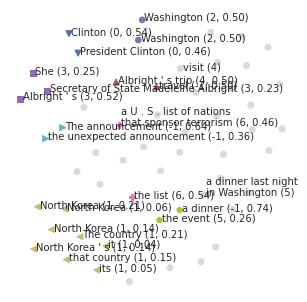

In [110]:
plot(63)